Suppose that you are given an AI route planning problem where a user wants to go from an arbitrary point A to B. The route could be formulated as a Markov Decision Problem (MDP) problem where reward may be related to good-looking landscapes, and transition probabilities are related to cost and time. I have collected some data from the traffic lab and preprocessed them to be included in a CSV file. Here is how I load them into my jupyterlab environment. 

In [1]:
import numpy as np
import pickle
import networkx as nx 
import pandas as pd 
from datetime import datetime 
from tqdm import tqdm 
import os 
from numba import njit 
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection 
plt.rcParams["figure.figsize"] = (15, 8)

/Users/sunandclouds/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
path = "routes_master_data.csv"
df = pd.read_csv(path) 
df 

,Route_ID,Route_Name,Direction,Private_Code,Point_ID,Order,RoutePointRef,StopPlace ID,StopPlace Name,StopPlace Private Code,...,Quay Longitude,Journey_ID,TransportMode,OperatorRef,DayTypeRef,PublicCode,PrivateCode,StopPointInJourneyPatternRef,ArrivalTime,DepartureTime
0,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,06:09:00
1,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,07:08:00
2,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,11:08:00
3,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,16:08:00
4,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,18:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312327,14010000621141260,Vallentuna station,inbound,669,14010000621141284,20,9022001059500001,9021001059500000,Markim,59500,...,18.036867,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,09:23:00,09:23:00
1312328,14010000621141260,Vallentuna station,inbound,669,14010000621141285,21,9022001060157006,9021001060157000,Vallentuna station,60157,...,18.078910,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,19:48:00,NaN
1312329,14010000621141260,Vallentuna station,inbound,669,14010000621141285,21,9022001060157006,9021001060157000,Vallentuna station,60157,...,18.078910,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,12:12:00,NaN
1312330,14010000621141260,Vallentuna station,inbound,669,14010000621141285,21,9022001060157006,9021001060157000,Vallentuna station,60157,...,18.078910,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,14:21:00,NaN


Note that some arrival time is NaN as well as the DepartureTime. Let's look closer what is going on. We will do so by randomly sample a couple of rows to get a better idea of the whole dataset. 

In [3]:
df[["ArrivalTime", "DepartureTime"]].sample(n=20)

,ArrivalTime,DepartureTime
1311626,07:52:00,07:52:00
1056126,15:57:41,15:57:41
376262,16:30:00,16:30:00
603169,09:37:00,09:37:00
877508,05:52:13,05:52:13
265476,19:48:00,19:48:00
1053058,18:28:25,18:28:25
569113,23:29:02,23:29:02
387530,08:19:31,08:19:31
802629,14:24:21,14:24:21


It looks like they are either the same number, or one of them is NaN. Let's verify that! 
1. Turn the NaNs into -infty. 
2. Turn the time into seconds. 
3. Multiply row-wise.   
If there is two NaN in a row, then -infty * -infty = infty. If only one is NaN, then number * -infty = -infty. We can then check for +infty. If there are none of these, then the hypothesis "Either the same number, or one of them is NaN." is holds.    

```python 
# step 1 
df[['ArrivalTime', 'DepartureTime']].fillna(-float("inf"), inplace=True) 
```      

<ipython-input-31-91e2ca78eaeb>:2: SettingWithCopyWarning:      A value is trying to be set on a copy of a slice from a DataFrame          See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy       df[['ArrivalTime', 'DepartureTime']].fillna(-float("inf"), inplace=True)    
    
```python 
# step 2 
# Convert time to seconds 
def time_to_seconds(time_str):     
    try:         
        h, m, s = map(int, time_str.split(':'))         
        return h * 3600 + m * 60 + s     
    except:         
        return -float("inf") 
    
df['ArrivalTime'] = df['ArrivalTime'].apply(time_to_seconds) df['DepartureTime'] = df['DepartureTime'].apply(time_to_seconds) 

# step 3 
row_prod = df[["ArrivalTime","DepartureTime"]].sample(n=20).prod(axis=1)(row_prod == float("inf")).sum() 
```    

    The result is 0, so there are no +inf. Let's check that the dataframe makes sense by using transpose to see all the columns.

```python
df.sample(20).T
```
    
<div> <style scoped>     .dataframe tbody tr th:only-of-type {         vertical-align: middle;     }      .dataframe tbody tr th {         vertical-align: top;     }      .dataframe thead th {         text-align: right;     } </style> <table border="1" class="dataframe">   <thead>     <tr style="text-align: right;">       <th></th>       <th>1068025</th>       <th>456759</th>       <th>8798</th>       <th>180540</th>       <th>784417</th>       <th>618435</th>       <th>347422</th>       <th>173312</th>       <th>107965</th>       <th>728308</th>       <th>900276</th>       <th>1085973</th>       <th>1183467</th>       <th>170319</th>       <th>747840</th>       <th>908494</th>       <th>1186744</th>       <th>731004</th>       <th>256139</th>       <th>114665</th>     </tr>   </thead>   <tbody>     <tr>       <th>Route_ID</th>       <td>14010000243459128</td>       <td>14010000314079264</td>       <td>14010000342248484</td>       <td>14010000568139441</td>       <td>14010000628714328</td>       <td>14010000407640261</td>       <td>14010000631454758</td>       <td>14010000618662008</td>       <td>14010000662322621</td>       <td>14010000340973678</td>       <td>14010000536511509</td>       <td>14010000662324787</td>       <td>14010000494929012</td>       <td>14010000527509761</td>       <td>14010000545908830</td>       <td>14010000552528316</td>       <td>14010000492969547</td>       <td>14010000001498055</td>       <td>14010000536798008</td>       <td>14010000662322767</td>     </tr>     <tr>       <th>Route_Name</th>       <td>Drevviksstrand</td>       <td>Valla torg</td>       <td>Lina hage</td>       <td>Länna industriområde</td>       <td>Stenhamra</td>       <td>Fruängen</td>       <td>Gullmarsplan</td>       <td>Överenhörna kyrka</td>       <td>Solna centrum</td>       <td>Gröndal</td>       <td>Nynäshamn</td>       <td>Sundbybergs</td>       <td>Jakobsberg - Bruttovägen- Högbyvägen</td>       <td>Näset</td>       <td>Kärrtorp</td>       <td>Hålludden</td>       <td>Södertälje</td>       <td>Bagarmossen</td>       <td>Stora Lappkärrsberget</td>       <td>Spånga station</td>     </tr>     <tr>       <th>Direction</th>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>inbound</td>       <td>inbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>inbound</td>       <td>outbound</td>       <td>outbound</td>       <td>inbound</td>       <td>outbound</td>       <td>outbound</td>     </tr>     <tr>       <th>Private_Code</th>       <td>742</td>       <td>164</td>       <td>752</td>       <td>831</td>       <td>176</td>       <td>703</td>       <td>4</td>       <td>787</td>       <td>113</td>       <td>161</td>       <td>43</td>       <td>595</td>       <td>564</td>       <td>203</td>       <td>163</td>       <td>468</td>       <td>40</td>       <td>161</td>       <td>50</td>       <td>119</td>     </tr>     <tr>       <th>Point_ID</th>       <td>14010000243459162</td>       <td>14010000314079273</td>       <td>14010000342248499</td>       <td>14010000568139464</td>       <td>14010000628714374</td>       <td>14010000407640279</td>       <td>14010000631454774</td>       <td>14010000618662018</td>       <td>14010000662322638</td>       <td>14010000340973732</td>       <td>14010000536511517</td>       <td>14010000662324800</td>       <td>14010000494929044</td>       <td>14010000527509766</td>       <td>14010000545908841</td>       <td>14010000552528323</td>       <td>14010000492969569</td>       <td>14010000001498075</td>       <td>14010000536798023</td>       <td>14010000662322795</td>     </tr>     <tr>       <th>Order</th>       <td>30</td>       <td>5</td>       <td>11</td>       <td>19</td>       <td>42</td>       <td>14</td>       <td>12</td>       <td>6</td>       <td>13</td>       <td>50</td>       <td>4</td>       <td>9</td>       <td>28</td>       <td>1</td>       <td>7</td>       <td>3</td>       <td>18</td>       <td>16</td>       <td>11</td>       <td>24</td>     </tr>     <tr>       <th>RoutePointRef</th>       <td>9022001080483001</td>       <td>9022001011725006</td>       <td>9022001075104002</td>       <td>9022001070675001</td>       <td>9022001015811001</td>       <td>9022001070114001</td>       <td>9022001010183003</td>       <td>9022001075114001</td>       <td>9022001012111002</td>       <td>9022001013077001</td>       <td>9022001006051001</td>       <td>9022001010553001</td>       <td>9022001051777002</td>       <td>9022001010032007</td>       <td>9022001013401003</td>       <td>9022001042010001</td>       <td>9022001005161001</td>       <td>9022001013057002</td>       <td>9022001060309001</td>       <td>9022001050109001</td>     </tr>     <tr>       <th>StopPlace ID</th>       <td>9021001080483000</td>       <td>9021001011725000</td>       <td>9021001075104000</td>       <td>9021001070675000</td>       <td>9021001015811000</td>       <td>9021001070114000</td>       <td>9021001010183000</td>       <td>9021001075114000</td>       <td>9021001012111000</td>       <td>9021001013077000</td>       <td>9021001006051000</td>       <td>9021001010553000</td>       <td>9021001051777000</td>       <td>9021001010032000</td>       <td>9021001013401000</td>       <td>9021001042010000</td>       <td>9021001005161000</td>       <td>9021001013057000</td>       <td>9021001060309000</td>       <td>9021001050109000</td>     </tr>     <tr>       <th>StopPlace Name</th>       <td>Rapsodivägen</td>       <td>Gullmarsplan</td>       <td>Gillestigen</td>       <td>Fäbodvägen</td>       <td>Stenhamra centrum</td>       <td>Heimdalsvägen</td>       <td>Dalagatan</td>       <td>Törnrosavägen</td>       <td>Mariehäll</td>       <td>Styrbjörnsvägen</td>       <td>Barkarby</td>       <td>Norrtull</td>       <td>Sätervägen</td>       <td>Ropsten</td>       <td>Fruängen</td>       <td>Hästhagen</td>       <td>Huddinge</td>       <td>Nippervägen</td>       <td>Professorsslingan</td>       <td>Markviksvägen</td>     </tr>     <tr>       <th>StopPlace Private Code</th>       <td>80483</td>       <td>11725</td>       <td>75104</td>       <td>70675</td>       <td>15811</td>       <td>70114</td>       <td>10183</td>       <td>75114</td>       <td>12111</td>       <td>13077</td>       <td>6051</td>       <td>10553</td>       <td>51777</td>       <td>10032</td>       <td>13401</td>       <td>42010</td>       <td>5161</td>       <td>13057</td>       <td>60309</td>       <td>50109</td>     </tr>     <tr>       <th>StopPlace Latitude</th>       <td>59.216467</td>       <td>59.298339</td>       <td>59.199638</td>       <td>59.220551</td>       <td>59.335056</td>       <td>59.254468</td>       <td>59.341461</td>       <td>59.205445</td>       <td>59.360612</td>       <td>59.309166</td>       <td>59.404576</td>       <td>59.350082</td>       <td>59.429896</td>       <td>59.357618</td>       <td>59.285583</td>       <td>59.320981</td>       <td>59.235823</td>       <td>59.285265</td>       <td>59.370127</td>       <td>59.370768</td>     </tr>     <tr>       <th>StopPlace Longitude</th>       <td>18.158555</td>       <td>18.080996</td>       <td>17.582675</td>       <td>18.151732</td>       <td>17.686897</td>       <td>17.989807</td>       <td>18.044852</td>       <td>17.606347</td>       <td>17.95361</td>       <td>18.002092</td>       <td>17.866036</td>       <td>18.045478</td>       <td>17.816924</td>       <td>18.103263</td>       <td>17.965448</td>       <td>18.397</td>       <td>17.977971</td>       <td>17.993227</td>       <td>18.060717</td>       <td>17.820795</td>     </tr>     <tr>       <th>Quay ID</th>       <td>9022001080483001</td>       <td>9022001011725006</td>       <td>9022001075104002</td>       <td>9022001070675001</td>       <td>9022001015811001</td>       <td>9022001070114001</td>       <td>9022001010183003</td>       <td>9022001075114001</td>       <td>9022001012111002</td>       <td>9022001013077001</td>       <td>9022001006051001</td>       <td>9022001010553001</td>       <td>9022001051777002</td>       <td>9022001010032007</td>       <td>9022001013401003</td>       <td>9022001042010001</td>       <td>9022001005161001</td>       <td>9022001013057002</td>       <td>9022001060309001</td>       <td>9022001050109001</td>     </tr>     <tr>       <th>Quay Name</th>       <td>Rapsodivägen</td>       <td>Gullmarsplan</td>       <td>Gillestigen</td>       <td>Fäbodvägen</td>       <td>Stenhamra centrum</td>       <td>Heimdalsvägen</td>       <td>Dalagatan</td>       <td>Törnrosavägen</td>       <td>Mariehäll</td>       <td>Styrbjörnsvägen</td>       <td>Barkarby</td>       <td>Norrtull</td>       <td>Sätervägen</td>       <td>Ropsten</td>       <td>Fruängen</td>       <td>Hästhagen</td>       <td>Huddinge</td>       <td>Nippervägen</td>       <td>Professorsslingan</td>       <td>Markviksvägen</td>     </tr>     <tr>       <th>Quay Private Code</th>       <td>1</td>       <td>6</td>       <td>2</td>       <td>1</td>       <td>1</td>       <td>1</td>       <td>3</td>       <td>1</td>       <td>2</td>       <td>1</td>       <td>1</td>       <td>1</td>       <td>2</td>       <td>7</td>       <td>3</td>       <td>1</td>       <td>1</td>       <td>2</td>       <td>1</td>       <td>1</td>     </tr>     <tr>       <th>Quay Latitude</th>       <td>59.216437</td>       <td>59.298674</td>       <td>59.199986</td>       <td>59.22071</td>       <td>59.335477</td>       <td>59.254647</td>       <td>59.341475</td>       <td>59.205521</td>       <td>59.360549</td>       <td>59.308876</td>       <td>59.404541</td>       <td>59.350265</td>       <td>59.42992</td>       <td>59.357371</td>       <td>59.285009</td>       <td>59.32085</td>       <td>59.23579</td>       <td>59.285116</td>       <td>59.369851</td>       <td>59.370703</td>     </tr>     <tr>       <th>Quay Longitude</th>       <td>18.1585</td>       <td>18.078492</td>       <td>17.582765</td>       <td>18.151487</td>       <td>17.68728</td>       <td>17.989029</td>       <td>18.044896</td>       <td>17.605771</td>       <td>17.95416</td>       <td>18.001029</td>       <td>17.866016</td>       <td>18.045543</td>       <td>17.816872</td>       <td>18.103223</td>       <td>17.965161</td>       <td>18.39706</td>       <td>17.978047</td>       <td>17.992828</td>       <td>18.061121</td>       <td>17.820958</td>     </tr>     <tr>       <th>Journey_ID</th>       <td>14010000640559994.0</td>       <td>14010000641291432.0</td>       <td>14010000509131792.0</td>       <td>14010000645773528.0</td>       <td>14010000640334882.0</td>       <td>14010000640575250.0</td>       <td>14010000666039278.0</td>       <td>14010000624453192.0</td>       <td>14010000666312272.0</td>       <td>14010000635833464.0</td>       <td>14010000665722308.0</td>       <td>14010000668520064.0</td>       <td>14010000631884508.0</td>       <td>14010000666484500.0</td>       <td>14010000635682316.0</td>       <td>14010000635246784.0</td>       <td>14010000656704736.0</td>       <td>14010000635648220.0</td>       <td>14010000664287812.0</td>       <td>14010000666767682.0</td>     </tr>     <tr>       <th>TransportMode</th>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>rail</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>rail</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>     </tr>     <tr>       <th>OperatorRef</th>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001003000000.0</td>       <td>9013001003000000.0</td>       <td>9013001001500000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001003000000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001006500000.0</td>       <td>9013001001000000.0</td>       <td>9013001003000000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001006500000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>     </tr>     <tr>       <th>DayTypeRef</th>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>o8i90v7t81i3t2ncq1u4t69cmhup38n1</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>ajm6vhddu9hnmdaqem1bdds1ursspmqv</td>       <td>qrb9l0nlg27pb1p1tsiuid5ukm2c0q7s</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>k4o5svkltk72ldhkqnva0g4rjf9cibk1</td>       <td>sjuggq8rt701qmk4obpsb80it74vr8o5</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>nb7f3541u51kalnec5mk4dnnjhkrlie9</td>     </tr>     <tr>       <th>PublicCode</th>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>       <td>NaN</td>     </tr>     <tr>       <th>PrivateCode</th>       <td>742.0</td>       <td>164.0</td>       <td>752.0</td>       <td>831.0</td>       <td>176.0</td>       <td>703.0</td>       <td>4.0</td>       <td>787.0</td>       <td>113.0</td>       <td>161.0</td>       <td>43.0</td>       <td>595.0</td>       <td>564.0</td>       <td>203.0</td>       <td>163.0</td>       <td>468.0</td>       <td>40.0</td>       <td>161.0</td>       <td>50.0</td>       <td>119.0</td>     </tr>     <tr>       <th>StopPointInJourneyPatternRef</th>       <td>14010000243459162.0</td>       <td>14010000314079272.0</td>       <td>14010000342248500.0</td>       <td>14010000568139464.0</td>       <td>14010000628714374.0</td>       <td>14010000407640280.0</td>       <td>14010000631454774.0</td>       <td>14010000618662018.0</td>       <td>14010000662322638.0</td>       <td>14010000340973732.0</td>       <td>14010000536511516.0</td>       <td>14010000662324800.0</td>       <td>14010000494929044.0</td>       <td>14010000527509766.0</td>       <td>14010000545908840.0</td>       <td>14010000552528324.0</td>       <td>14010000492969568.0</td>       <td>14010000001498076.0</td>       <td>14010000536798024.0</td>       <td>14010000662322796.0</td>     </tr>     <tr>       <th>ArrivalTime</th>       <td>29861.0</td>       <td>36420.0</td>       <td>64082.0</td>       <td>58163.0</td>       <td>39300.0</td>       <td>55280.0</td>       <td>32792.0</td>       <td>40263.0</td>       <td>33303.0</td>       <td>62171.0</td>       <td>64860.0</td>       <td>13239.0</td>       <td>31518.0</td>       <td>-inf</td>       <td>31980.0</td>       <td>49080.0</td>       <td>29400.0</td>       <td>19981.0</td>       <td>34324.0</td>       <td>2424.0</td>     </tr>     <tr>       <th>DepartureTime</th>       <td>29861.0</td>       <td>36420.0</td>       <td>64082.0</td>       <td>58163.0</td>       <td>39300.0</td>       <td>55280.0</td>       <td>32792.0</td>       <td>40263.0</td>       <td>33303.0</td>       <td>62171.0</td>       <td>64860.0</td>       <td>13239.0</td>       <td>31518.0</td>       <td>49920.0</td>       <td>31980.0</td>       <td>49080.0</td>       <td>29400.0</td>       <td>19981.0</td>       <td>34324.0</td>       <td>2424.0</td>     </tr>   </tbody> </table> </div>    We can see that the PublicCode got a lot of NaNs, we can check if everything are NaNs. We do so by summing the number of occurences of NaNs and see if the number of elements matches with the number of data points in the dataset.   ```python np.isnan(df["PublicCode"]).sum() == len(df) ```         True    It looks like everything seems to be NaNs. So we can remove PublicCode column.   ```python df = df.drop("PublicCode", axis=1) ```   ```python df.sample(20).T ```     <div> <style scoped>     .dataframe tbody tr th:only-of-type {         vertical-align: middle;     }      .dataframe tbody tr th {         vertical-align: top;     }      .dataframe thead th {         text-align: right;     } </style> <table border="1" class="dataframe">   <thead>     <tr style="text-align: right;">       <th></th>       <th>810291</th>       <th>802316</th>       <th>584135</th>       <th>1298600</th>       <th>262213</th>       <th>637469</th>       <th>948009</th>       <th>783149</th>       <th>101337</th>       <th>846003</th>       <th>1037186</th>       <th>435418</th>       <th>1200305</th>       <th>505482</th>       <th>359203</th>       <th>873525</th>       <th>968364</th>       <th>1019935</th>       <th>434546</th>       <th>774964</th>     </tr>   </thead>   <tbody>     <tr>       <th>Route_ID</th>       <td>14010000638766820</td>       <td>14010000510055164</td>       <td>14010000644650772</td>       <td>14010000559397911</td>       <td>14010000510056672</td>       <td>14010000229631432</td>       <td>14010000562042753</td>       <td>14010000628714328</td>       <td>14010000652647450</td>       <td>14010000339110777</td>       <td>14010000662322318</td>       <td>14010000406194407</td>       <td>14010000328321274</td>       <td>14010000003615322</td>       <td>14010000666176944</td>       <td>14010000644391033</td>       <td>14010000606953015</td>       <td>14010000621892802</td>       <td>14010000406194892</td>       <td>14010000633436913</td>     </tr>     <tr>       <th>Route_Name</th>       <td>Frihamnen</td>       <td>Slussen</td>       <td>Jakobsbergs station</td>       <td>Tomteboda postterminal</td>       <td>Västra Orminge</td>       <td>Tumba station</td>       <td>Slussen</td>       <td>Stenhamra</td>       <td>Upplands Väsby station</td>       <td>Björkvik</td>       <td>Spånga station</td>       <td>Norrtälje</td>       <td>Stuvsta</td>       <td>Årsta slott</td>       <td>Spånga station</td>       <td>Björnkulla</td>       <td>Rinkeby centrum</td>       <td>Åkersberga station</td>       <td>Norrtälje</td>       <td>Nynäshamn station</td>     </tr>     <tr>       <th>Direction</th>       <td>inbound</td>       <td>inbound</td>       <td>outbound</td>       <td>outbound</td>       <td>outbound</td>       <td>inbound</td>       <td>inbound</td>       <td>inbound</td>       <td>inbound</td>       <td>inbound</td>       <td>inbound</td>       <td>inbound</td>       <td>outbound</td>       <td>outbound</td>       <td>inbound</td>       <td>inbound</td>       <td>outbound</td>       <td>outbound</td>       <td>inbound</td>       <td>outbound</td>     </tr>     <tr>       <th>Private_Code</th>       <td>1</td>       <td>444</td>       <td>560</td>       <td>507</td>       <td>471</td>       <td>716</td>       <td>401</td>       <td>176</td>       <td>524</td>       <td>317</td>       <td>116</td>       <td>637</td>       <td>705</td>       <td>846</td>       <td>112</td>       <td>713</td>       <td>511</td>       <td>624</td>       <td>637</td>       <td>783</td>     </tr>     <tr>       <th>Point_ID</th>       <td>14010000638766833</td>       <td>14010000510055173</td>       <td>14010000644650788</td>       <td>14010000559397930</td>       <td>14010000510056681</td>       <td>14010000229631440</td>       <td>14010000562042765</td>       <td>14010000628714360</td>       <td>14010000652647455</td>       <td>14010000339110816</td>       <td>14010000662322334</td>       <td>14010000406194511</td>       <td>14010000328321302</td>       <td>14010000003615328</td>       <td>14010000666176964</td>       <td>14010000644391044</td>       <td>14010000606953021</td>       <td>14010000621892832</td>       <td>14010000406194943</td>       <td>14010000633436964</td>     </tr>     <tr>       <th>Order</th>       <td>9</td>       <td>5</td>       <td>12</td>       <td>15</td>       <td>5</td>       <td>4</td>       <td>8</td>       <td>28</td>       <td>1</td>       <td>35</td>       <td>12</td>       <td>100</td>       <td>24</td>       <td>2</td>       <td>16</td>       <td>7</td>       <td>2</td>       <td>26</td>       <td>47</td>       <td>47</td>     </tr>     <tr>       <th>RoutePointRef</th>       <td>9022001010421002</td>       <td>9022001040421002</td>       <td>9022001050540001</td>       <td>9022001050121001</td>       <td>9022001040175003</td>       <td>9022001070335002</td>       <td>9022001040039002</td>       <td>9022001015327001</td>       <td>9022001061060003</td>       <td>9022001015886001</td>       <td>9022001012486001</td>       <td>9022001064007002</td>       <td>9022001070264001</td>       <td>9022001080875002</td>       <td>9022001012030001</td>       <td>9022001070245002</td>       <td>9022001051530002</td>       <td>9022001062427002</td>       <td>9022001063709002</td>       <td>9022001075481001</td>     </tr>     <tr>       <th>StopPlace ID</th>       <td>9021001010421000</td>       <td>9021001040421000</td>       <td>9021001050540000</td>       <td>9021001050121000</td>       <td>9021001040175000</td>       <td>9021001070335000</td>       <td>9021001040039000</td>       <td>9021001015327000</td>       <td>9021001061060000</td>       <td>9021001015886000</td>       <td>9021001012486000</td>       <td>9021001064007000</td>       <td>9021001070264000</td>       <td>9021001080875000</td>       <td>9021001012030000</td>       <td>9021001070245000</td>       <td>9021001051530000</td>       <td>9021001062427000</td>       <td>9021001063709000</td>       <td>9021001075481000</td>     </tr>     <tr>       <th>StopPlace Name</th>       <td>Mariebergsgatan</td>       <td>Korset</td>       <td>Jästfabriken</td>       <td>Västra skogen</td>       <td>Storängen</td>       <td>Malmtorp</td>       <td>Klisätravägen</td>       <td>Ekvägen</td>       <td>Arninge station</td>       <td>Björkvik</td>       <td>Skattegårdsvägen</td>       <td>Malsta vägskäl</td>       <td>Djupåsvägen</td>       <td>Ribbyskolan</td>       <td>Grenvägen</td>       <td>Falks backe</td>       <td>Mjölbyplan</td>       <td>Fjärilsvägen</td>       <td>Steneborg</td>       <td>Söder Enby</td>     </tr>     <tr>       <th>StopPlace Private Code</th>       <td>10421</td>       <td>40421</td>       <td>50540</td>       <td>50121</td>       <td>40175</td>       <td>70335</td>       <td>40039</td>       <td>15327</td>       <td>61060</td>       <td>15886</td>       <td>12486</td>       <td>64007</td>       <td>70264</td>       <td>80875</td>       <td>12030</td>       <td>70245</td>       <td>51530</td>       <td>62427</td>       <td>63709</td>       <td>75481</td>     </tr>     <tr>       <th>StopPlace Latitude</th>       <td>59.331613</td>       <td>59.332856</td>       <td>59.47519</td>       <td>59.347599</td>       <td>59.309089</td>       <td>59.170533</td>       <td>59.270664</td>       <td>59.287193</td>       <td>59.459144</td>       <td>59.404838</td>       <td>59.379159</td>       <td>59.77551</td>       <td>59.250518</td>       <td>59.119392</td>       <td>59.335991</td>       <td>59.203049</td>       <td>59.38679</td>       <td>59.478175</td>       <td>60.01731</td>       <td>58.988436</td>     </tr>     <tr>       <th>StopPlace Longitude</th>       <td>18.024003</td>       <td>18.26493</td>       <td>17.916975</td>       <td>18.003034</td>       <td>18.175768</td>       <td>17.797896</td>       <td>18.177664</td>       <td>17.802188</td>       <td>18.140032</td>       <td>17.731052</td>       <td>17.848745</td>       <td>18.672416</td>       <td>18.005894</td>       <td>18.107794</td>       <td>17.967349</td>       <td>17.895317</td>       <td>17.924704</td>       <td>18.321209</td>       <td>18.797958</td>       <td>17.815867</td>     </tr>     <tr>       <th>Quay ID</th>       <td>9022001010421002</td>       <td>9022001040421002</td>       <td>9022001050540001</td>       <td>9022001050121001</td>       <td>9022001040175003</td>       <td>9022001070335002</td>       <td>9022001040039002</td>       <td>9022001015327001</td>       <td>9022001061060003</td>       <td>9022001015886001</td>       <td>9022001012486001</td>       <td>9022001064007002</td>       <td>9022001070264001</td>       <td>9022001080875002</td>       <td>9022001012030001</td>       <td>9022001070245002</td>       <td>9022001051530002</td>       <td>9022001062427002</td>       <td>9022001063709002</td>       <td>9022001075481001</td>     </tr>     <tr>       <th>Quay Name</th>       <td>Mariebergsgatan</td>       <td>Korset</td>       <td>Jästfabriken</td>       <td>Västra skogen</td>       <td>Storängen</td>       <td>Malmtorp</td>       <td>Klisätravägen</td>       <td>Ekvägen</td>       <td>Arninge station</td>       <td>Björkvik</td>       <td>Skattegårdsvägen</td>       <td>Malsta vägskäl</td>       <td>Djupåsvägen</td>       <td>Ribbyskolan</td>       <td>Grenvägen</td>       <td>Falks backe</td>       <td>Mjölbyplan</td>       <td>Fjärilsvägen</td>       <td>Steneborg</td>       <td>Söder Enby</td>     </tr>     <tr>       <th>Quay Private Code</th>       <td>2</td>       <td>2</td>       <td>1</td>       <td>1</td>       <td>3</td>       <td>2</td>       <td>2</td>       <td>1</td>       <td>3</td>       <td>1</td>       <td>1</td>       <td>2</td>       <td>1</td>       <td>2</td>       <td>1</td>       <td>2</td>       <td>2</td>       <td>2</td>       <td>2</td>       <td>1</td>     </tr>     <tr>       <th>Quay Latitude</th>       <td>59.331749</td>       <td>59.332758</td>       <td>59.474789</td>       <td>59.347208</td>       <td>59.309027</td>       <td>59.170871</td>       <td>59.271464</td>       <td>59.287213</td>       <td>59.459386</td>       <td>59.404838</td>       <td>59.379159</td>       <td>59.774904</td>       <td>59.250535</td>       <td>59.119134</td>       <td>59.335796</td>       <td>59.202469</td>       <td>59.386708</td>       <td>59.478429</td>       <td>60.017265</td>       <td>58.988527</td>     </tr>     <tr>       <th>Quay Longitude</th>       <td>18.025424</td>       <td>18.264903</td>       <td>17.917263</td>       <td>18.003818</td>       <td>18.175727</td>       <td>17.798073</td>       <td>18.177862</td>       <td>17.801946</td>       <td>18.139892</td>       <td>17.731052</td>       <td>17.848745</td>       <td>18.67266</td>       <td>18.004247</td>       <td>18.107445</td>       <td>17.967419</td>       <td>17.893873</td>       <td>17.924557</td>       <td>18.320981</td>       <td>18.797901</td>       <td>17.815438</td>     </tr>     <tr>       <th>Journey_ID</th>       <td>14010000669091968.0</td>       <td>14010000648940078.0</td>       <td>14010000662258508.0</td>       <td>14010000666234786.0</td>       <td>14010000641029836.0</td>       <td>14010000640018732.0</td>       <td>14010000562051850.0</td>       <td>14010000640334328.0</td>       <td>14010000665353570.0</td>       <td>14010000637474352.0</td>       <td>14010000666252792.0</td>       <td>14010000667595746.0</td>       <td>14010000640564680.0</td>       <td>14010000623048816.0</td>       <td>14010000666297148.0</td>       <td>14010000649131900.0</td>       <td>14010000666234610.0</td>       <td>14010000665344092.0</td>       <td>14010000667601868.0</td>       <td>14010000633444480.0</td>     </tr>     <tr>       <th>TransportMode</th>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>       <td>bus</td>     </tr>     <tr>       <th>OperatorRef</th>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001004500000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001003000000.0</td>       <td>9013001001500000.0</td>       <td>9013001004500000.0</td>       <td>9013001001500000.0</td>       <td>9013001001000000.0</td>       <td>9013001004500000.0</td>       <td>9013001001000000.0</td>       <td>9013001003000000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001001000000.0</td>       <td>9013001004500000.0</td>       <td>9013001004500000.0</td>       <td>9013001003000000.0</td>     </tr>     <tr>       <th>DayTypeRef</th>       <td>iti48jdltg20h91b24mgmdpg7hofr6s5</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>d9kunvs00qjc39j9p1ls4cgknuhrs72b</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>o8i90v7t81i3t2ncq1u4t69cmhup38n1</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>5i1tfl7qc044lo8hon242mf5hb39ae7s</td>       <td>d9kunvs00qjc39j9p1ls4cgknuhrs72b</td>       <td>547uul483gal6iv42af5a823g9gjc3na</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>tvpsnr867mbh6f55dd3k7d3ocjdh7hb4</td>       <td>r6crba8dhs04rvu7isgr27jl6jr8joo3</td>       <td>8rclpiokhqnl1guavq1u0nlju2eqprqo</td>       <td>d9kunvs00qjc39j9p1ls4cgknuhrs72b</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>       <td>bncpagqso7dvr0jmc2o233d3een6g00p</td>     </tr>     <tr>       <th>PrivateCode</th>       <td>1.0</td>       <td>444.0</td>       <td>560.0</td>       <td>507.0</td>       <td>471.0</td>       <td>716.0</td>       <td>401.0</td>       <td>176.0</td>       <td>524.0</td>       <td>317.0</td>       <td>116.0</td>       <td>637.0</td>       <td>705.0</td>       <td>846.0</td>       <td>112.0</td>       <td>713.0</td>       <td>511.0</td>       <td>624.0</td>       <td>637.0</td>       <td>783.0</td>     </tr>     <tr>       <th>StopPointInJourneyPatternRef</th>       <td>14010000638766832.0</td>       <td>14010000510055172.0</td>       <td>14010000644650788.0</td>       <td>14010000559397930.0</td>       <td>14010000510056680.0</td>       <td>14010000229631440.0</td>       <td>14010000562042764.0</td>       <td>14010000628714360.0</td>       <td>14010000652647456.0</td>       <td>14010000339110816.0</td>       <td>14010000662322334.0</td>       <td>14010000406194512.0</td>       <td>14010000328321302.0</td>       <td>14010000003615328.0</td>       <td>14010000666176964.0</td>       <td>14010000644391044.0</td>       <td>14010000606953020.0</td>       <td>14010000621892832.0</td>       <td>14010000406194944.0</td>       <td>14010000633436964.0</td>     </tr>     <tr>       <th>ArrivalTime</th>       <td>40514.0</td>       <td>34380.0</td>       <td>43710.0</td>       <td>54300.0</td>       <td>59539.0</td>       <td>45183.0</td>       <td>73596.0</td>       <td>35815.0</td>       <td>-inf</td>       <td>34140.0</td>       <td>62100.0</td>       <td>30407.0</td>       <td>34951.0</td>       <td>29885.0</td>       <td>8367.0</td>       <td>72904.0</td>       <td>52654.0</td>       <td>70556.0</td>       <td>69249.0</td>       <td>41070.0</td>     </tr>     <tr>       <th>DepartureTime</th>       <td>40514.0</td>       <td>34380.0</td>       <td>43710.0</td>       <td>54300.0</td>       <td>59539.0</td>       <td>45183.0</td>       <td>73596.0</td>       <td>35815.0</td>       <td>79800.0</td>       <td>-inf</td>       <td>62100.0</td>       <td>30407.0</td>       <td>34951.0</td>       <td>29885.0</td>       <td>8367.0</td>       <td>72904.0</td>       <td>52654.0</td>       <td>70556.0</td>       <td>69249.0</td>       <td>41070.0</td>     </tr>   </tbody> </table> </div>   

# Data analysis

Now, given this snapshot of data, begin by create a list that explains how each variable may contribute to the mathematical model of route planning. Here's a list explaining how each variable may contribute to the mathematical model of route planning:

1. **Route_ID**: This variable can be used to identify unique routes in the system. In the route planning model, it can be used to determine the specific route that a user is taking.

2. **Route_Name**: This variable provides a human-readable name for each route. It may not be directly used in the mathematical model but can be useful for displaying information to the user.

3. **Direction**: This variable indicates the direction of travel for each route. In the route planning model, it can be used to determine the order of stops along a route.

4. **Private_Code**: This variable appears to be a unique identifier for each stop or route. It may be used in the route planning model to identify specific stops or routes.

5. **Point_ID**: This variable is a unique identifier for each point along a route. In the route planning model, it can be used to determine the order of points along a route.

6. **Order**: This variable indicates the order of each point along a route. In the route planning model, it can be used to determine the sequence of points that a user will visit.

7. **RoutePointRef**: This variable appears to be a reference to a specific point along a route. It may be used in the route planning model to identify specific points along a route.

8. **StopPlace ID**: This variable is a unique identifier for each stop along a route. In the route planning model, it can be used to determine the specific stops that a user will visit.

9. **StopPlace Name**: This variable provides a human-readable name for each stop. It may not be directly used in the mathematical model but can be useful for displaying information to the user.

10. **StopPlace Private Code**: This variable appears to be a unique identifier for each stop. It may be used in the route planning model to identify specific stops.

11. **StopPlace Latitude** and **StopPlace Longitude**: These variables provide the geographic coordinates of each stop. In the route planning model, they can be used to calculate distances and travel times between stops.

12. **Quay ID**: This variable appears to be a unique identifier for each quay or platform. It may be used in the route planning model to identify specific quays or platforms.

13. **Quay Name**: This variable provides a human-readable name for each quay or platform. It may not be directly used in the mathematical model but can be useful for displaying information to the user.

14. **Quay Private Code**: This variable appears to be a unique identifier for each quay or platform. It may be used in the route planning model to identify specific quays or platforms.

15. **Quay Latitude** and **Quay Longitude**: These variables provide the geographic coordinates of each quay or platform. In the route planning model, they can be used to calculate distances and travel times between quays or platforms.

16. **Journey_ID**: This variable is a unique identifier for each journey or trip. In the route planning model, it can be used to determine the specific journey that a user is taking.

17. **TransportMode**: This variable indicates the mode of transportation for each journey. In the route planning model, it can be used to determine the specific transportation mode that a user will use.

18. **OperatorRef**: This variable appears to be a reference to a specific transportation operator. It may be used in the route planning model to identify specific operators.

19. **DayTypeRef**: This variable appears to be a reference to a specific day type or schedule. It may be used in the route planning model to determine the specific schedule that a user will follow.

20. **PrivateCode**: This variable appears to be a unique identifier for each stop or route. It may be used in the route planning model to identify specific stops or routes.

21. **StopPointInJourneyPatternRef**: This variable appears to be a reference to a specific stop or point along a journey. It may be used in the route planning model to identify specific stops or points.

22. **ArrivalTime** and **DepartureTime**: These variables provide the arrival and departure times for each stop or point along a journey. In the route planning model, they can be used to determine the specific times that a user will arrive at or depart from each stop.

In terms of the mathematical model of route planning, the following variables are likely to be most relevant:

* **StopPlace Latitude** and **StopPlace Longitude**: These variables can be used to calculate distances and travel times between stops.
* **ArrivalTime** and **DepartureTime**: These variables can be used to determine the specific times that a user will arrive at or depart from each stop.
* **TransportMode**: This variable can be used to determine the specific transportation mode that a user will use.
* **Route_Name**: This is used to distinguish between different edges. 
* **StopPlace Name**: This is used to distinguish between different nodes.

Note that we don't need **Quay Latitude** and **Quay Longitude** as these varibales have approximately the same values as **StopPlace Latitude** and **StopPlace Longitude** (see table above).

# Creating the graph

Now, based on the most relevant variables proposed above, it is possible to construct a graph in a dictionary format. Here's a high-level summary of the `create_graph_from_csv` function:

1.  The function loads a CSV file into a pandas DataFrame.
2.  It creates a graph dictionary with nodes representing stops and edges representing connections between stops.
3.  The function iterates over the DataFrame to create nodes and add their attributes (stop name, route name, latitude, longitude, arrival time, departure time, and transport mode).
4.  It groups the DataFrame by Route ID and iterates over each route to add connections between stops.
5.  For each pair of consecutive stops in a route, it calculates the travel time between them and updates the travel time in the graph if it's less than the existing travel time.
6.  Finally, the function returns the constructed graph.

The graph is represented as a dictionary where each key is a stop ID, and the corresponding value is another dictionary containing the stop's attributes and a dictionary of its neighbors. Each neighbor is represented by a dictionary with the neighbor's stop ID, travel time, set of route IDs, and transport mode.

In [4]:
def time_difference(time1, time2):
    """Calculate time difference in seconds"""
    t1 = datetime.strptime(time1, "%H:%M:%S")
    t2 = datetime.strptime(time2, "%H:%M:%S")
    return abs((t2 - t1).total_seconds())

def create_graph_from_csv(path):
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(path)
    
    # Initialize an empty graph dictionary
    graph = {}

    # First pass: Create all nodes and initialize with empty neighbor dictionaries
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Creating nodes"):
        # Get the stop ID from the current row
        stop_id = row['StopPlace ID']
        
        # If the stop ID is not already in the graph, add it
        if stop_id not in graph:
            # Create a new node with the stop ID and initialize its attributes
            graph[stop_id] = {
                'neighbors': {},  # Initialize an empty dictionary for neighbors
                'stop_name': row['StopPlace Name'],  # Get the stop name
                'stop_latitude': row['StopPlace Latitude'],  # Get the stop latitude
                'stop_longitude': row['StopPlace Longitude'],  # Get the stop longitude
                'arrival_time': row['ArrivalTime'],  # Get the arrival time
                'departure_time': row['DepartureTime'],  # Get the departure time
                'transport_mode': row['TransportMode']  # Get the transport mode
            }

    # Second pass: Add connections between nodes
    # Group the DataFrame by Route ID
    grouped = df.groupby('Route_ID')
    
    # Iterate over each route
    for route_id, route_df in tqdm(grouped, total=len(grouped), desc="Processing routes"):
        # Sort the route DataFrame by Order
        route_df = route_df.sort_values('Order')
        
        # Iterate over each pair of consecutive stops in the route
        for i in range(len(route_df) - 1):
            # Get the current and next stops
            current_stop = route_df.iloc[i]
            next_stop = route_df.iloc[i+1]
            
            # Get the current and next stop IDs
            current_id = current_stop['StopPlace ID']
            next_id = next_stop['StopPlace ID']
            
            # If the current and next stop IDs are different (avoid self-loops)
            if current_id != next_id:
                # If the next stop ID is not already in the current stop's neighbors
                if next_id not in graph[current_id]['neighbors']:
                    # Create a new neighbor entry with default values
                    graph[current_id]['neighbors'][next_id] = {
                        'travel_time': float('inf'),  # Initialize travel time to infinity
                        'route_name': current_stop['Route_Name'],  # Get the route name
                        'transport_mode': current_stop['TransportMode']  # Get the transport mode
                    }
                
                # If the current stop's departure time and next stop's arrival time are not NaN
                if pd.notnull(current_stop['DepartureTime']) and pd.notnull(next_stop['ArrivalTime']):
                    # Calculate the travel time between the current and next stops
                    travel_time = time_difference(current_stop['DepartureTime'], next_stop['ArrivalTime'])
                    
                    # If the calculated travel time is less than the existing travel time
                    if travel_time < graph[current_id]['neighbors'][next_id]['travel_time']:
                        # Update the travel time
                        graph[current_id]['neighbors'][next_id]['travel_time'] = travel_time

    # Return the constructed graph
    return graph

# Usage
path = "routes_master_data.csv"
graph = create_graph_from_csv(path)
with open('graph.pickle', 'wb') as file:
    pickle.dump(graph, file)

print("Sample of the graph:")
print(list(graph.items())[:1])

Processing routes: 100%|██████████| 3150/3150 [02:47<00:00, 18.81it/s] 


Sample of the graph:
[(9021001064146000, {'neighbors': {9021001062573000: {'travel_time': 61.0, 'route_name': 'Norrtälje', 'transport_mode': 'bus'}, 9021001063054000: {'travel_time': 367.0, 'route_name': 'Rimbo', 'transport_mode': 'bus'}, 9021001064894000: {'travel_time': 17715.0, 'route_name': 'Grind', 'transport_mode': 'bus'}, 9021001062195000: {'travel_time': 74.0, 'route_name': 'Söderhalls', 'transport_mode': 'bus'}, 9021001062263000: {'travel_time': 6120.0, 'route_name': 'Stockholm', 'transport_mode': 'bus'}, 9021001060050000: {'travel_time': 420.0, 'route_name': 'Norrtälje', 'transport_mode': 'bus'}, 9021001064007000: {'travel_time': 241.0, 'route_name': 'Singö', 'transport_mode': 'bus'}, 9021001063265000: {'travel_time': 420.0, 'route_name': 'Norrtälje-Rådmansö-Norrtälje', 'transport_mode': 'bus'}, 9021001062571000: {'travel_time': 37.0, 'route_name': 'Norrtälje', 'transport_mode': 'bus'}, 9021001059510000: {'travel_time': 1242.0, 'route_name': 'Södra Lohärad', 'transport_mode':

# Graph visualization
We can visualize the graph using networkx. Here, the position of the nodes are represented as stop_latitude and stop_longitude and the edges represents the travel_time.

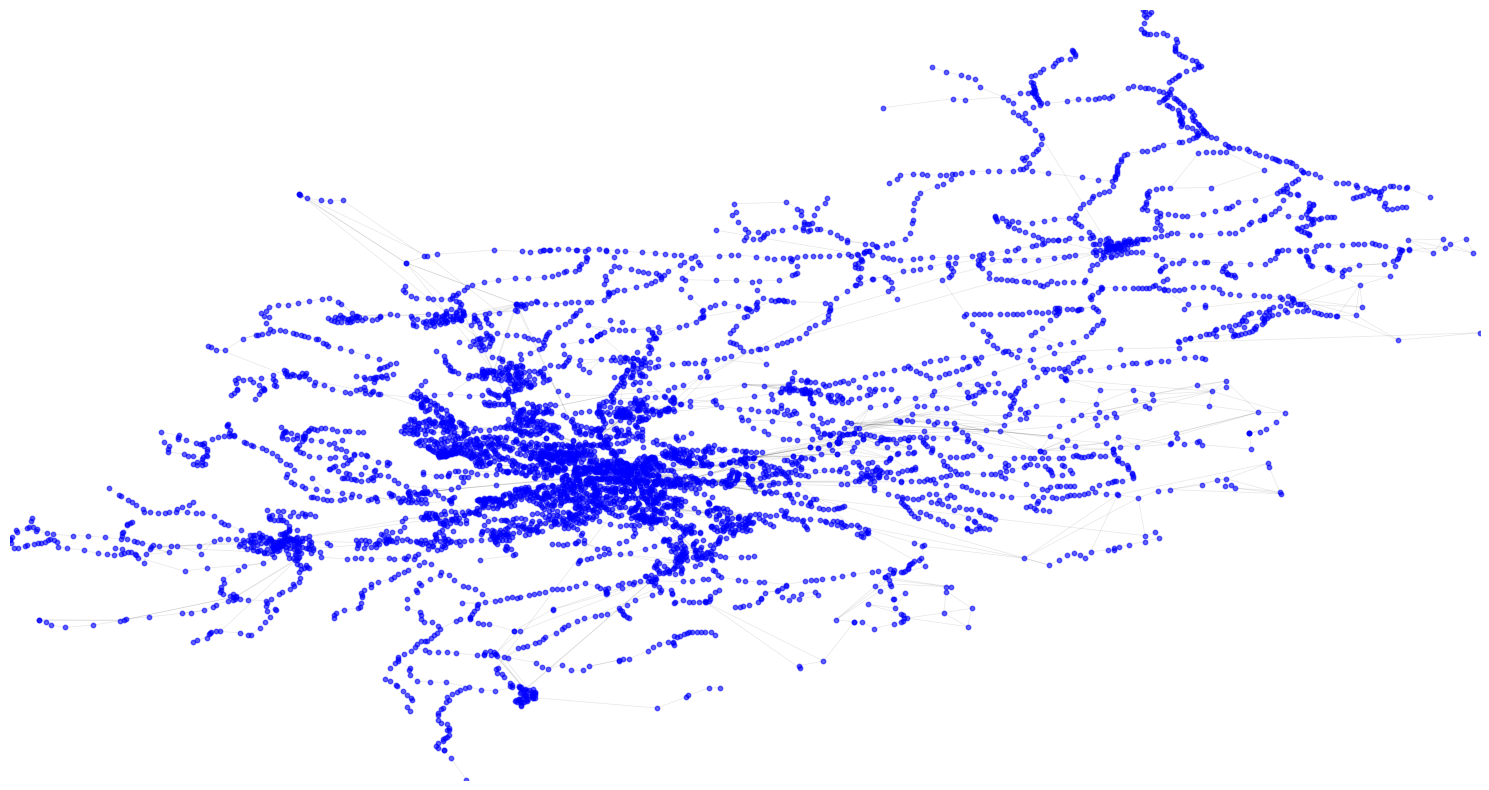

In [5]:
def visualize_graph(graph, node_size=10, edge_alpha=0.1):
    # Create a NetworkX graph from the dictionary
    G = nx.Graph()
    
    # Add nodes
    regular_stops = []
    quay_stops = []
    for node, data in graph.items():
        G.add_node(node, pos=(data['stop_longitude'], data['stop_latitude']))
        regular_stops.append(node)
    
    # Add edges
    for node, data in graph.items():
        for neighbor, edge_data in data['neighbors'].items():
            G.add_edge(node, neighbor, weight=edge_data['travel_time'])
    
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw edges
    edges = G.edges()
    edge_collection = LineCollection(
        [np.array([pos[u], pos[v]]) for u, v in edges],
        colors='black',
        linewidths=0.5,
        alpha=edge_alpha,
        zorder=1
    )
    plt.gca().add_collection(edge_collection)
    
    # Draw regular stops
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=regular_stops,
        node_size=node_size,
        node_color='blue',
        alpha=0.6,
    )
    
    
    # Set axis limits
    plt.xlim(min(x for x, _ in pos.values()), max(x for x, _ in pos.values()))
    plt.ylim(min(y for _, y in pos.values()), max(y for _, y in pos.values()))
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("graph.png", dpi=300, bbox_inches='tight')
    plt.show()

# Assuming 'graph' is your dictionary graph
visualize_graph(graph)

Make a comprehensive summary of what this notebook is about.

In [10]:
%run augmented_local_generation.py
from IPython.core.getipython import get_ipython
from IPython.display import Markdown

path = "exploratory data analysis.ipynb"
model = "llama-3.1-70b-versatile"
result = run_conversion(path, model)

# Create a new cell with the display command
get_ipython().set_next_input("Markdown(result)", replace=False)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01hqzv5y58e728xjrhnzmqtw8e` on : Limit 500000, Used 501667, Requested 17132. Please try again in 54m8.5186s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01hqzv5y58e728xjrhnzmqtw8e` on : Limit 500000, Used 501663, Requested 17132. Please try again in 54m7.8196s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

In [9]:
Markdown(result)

This notebook is about exploratory data analysis and route planning using a Markov Decision Process (MDP) problem. The data is collected from a traffic lab and preprocessed into a CSV file. The notebook loads the data into a pandas DataFrame and performs various operations to understand the structure and content of the data.

The notebook first loads the necessary libraries, including pandas, numpy, networkx, and matplotlib. It then loads the CSV file into a pandas DataFrame and displays the first few rows of the data.

The notebook then performs various data analysis tasks, including:

1.  Checking for missing values: The notebook checks for missing values in the DataFrame and finds that there are no missing values.
2.  Data type conversion: The notebook converts the 'ArrivalTime' and 'DepartureTime' columns to seconds.
3.  Data sampling: The notebook randomly samples 20 rows from the DataFrame to get a better idea of the data.
4.  Data transposition: The notebook transposes the DataFrame to see all the columns.
5.  Removing unnecessary columns: The notebook removes the 'PublicCode' column, which contains only NaN values.

The notebook then creates a graph from the data using the 'create_graph_from_csv' function. The function loads the CSV file into a pandas DataFrame, creates nodes and edges, and adds connections between nodes. The graph is represented as a dictionary where each key is a stop ID, and the corresponding value is another dictionary containing the stop's attributes and a dictionary of its neighbors.

Finally, the notebook visualizes the graph using networkx. The position of the nodes is represented as stop_latitude and stop_longitude, and the edges represent the travel_time. The notebook draws edges, regular stops, and sets axis limits.

Overall, this notebook is about exploratory data analysis and route planning using a Markov Decision Process (MDP) problem. It loads the data, performs various data analysis tasks, creates a graph, and visualizes the graph.